In [1]:
# import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np

from PIL import Image

import time
import warnings
warnings.filterwarnings("ignore")

## Extracting Hearts Template

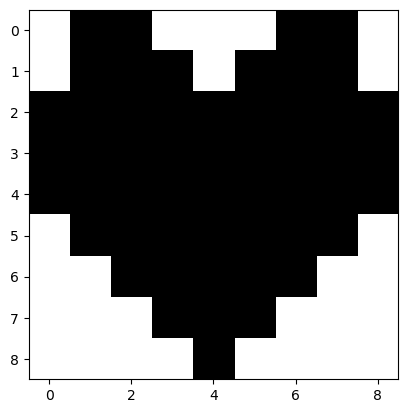

In [2]:
template_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heart_template.png").convert("L")
template_img = torch.tensor(np.array(template_img))/255.0
plt.imshow(template_img, cmap='gray')

In [3]:
template_img = template_img.flatten()

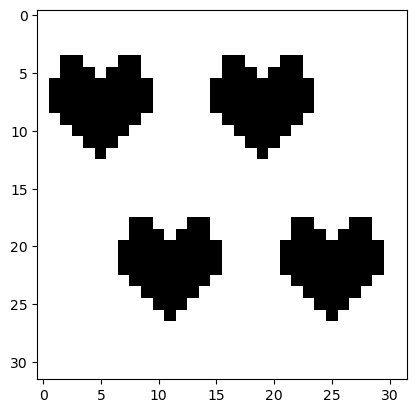

In [4]:
full_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heartss.png").convert("L")
full_img = torch.tensor(np.array(full_img))/255.0
plt.imshow(full_img, cmap='gray')

In [5]:
unfold = torch.nn.Unfold(kernel_size=(9,9),stride=3)
img_patches = unfold(full_img.unsqueeze(0).unsqueeze(0))
img_patches = img_patches.squeeze(0).T
print("Number of image patches:", img_patches.shape[0])
print("Single Image Patch Shape:", img_patches.shape[1])

Number of image patches: 64
Single Image Patch Shape: 81


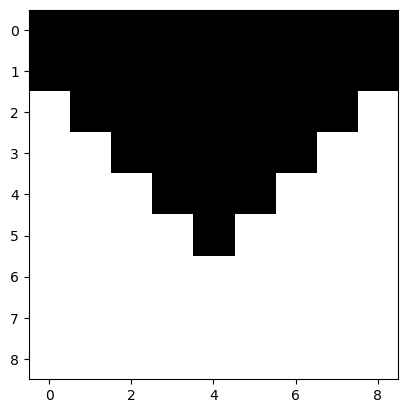

In [6]:
ex_patch = img_patches[-1].reshape(9,9)
plt.imshow(ex_patch, cmap='gray')

## Getting Wavefunction of Dataset

In [7]:
n_qubits = math.ceil(math.log2(img_patches.shape[1]))
n_ancillas = math.ceil(math.log2(img_patches.shape[0]))
total_qubits = n_qubits + n_ancillas
print("Number of qubits:", n_qubits)
print("Number of ancillas:", n_ancillas)

Number of qubits: 7
Number of ancillas: 6


In [8]:
def prepare_padded_data(dataset):

    n = math.ceil(math.log2(dataset.shape[1]))
    padded_data = torch.zeros((dataset.shape[0], 2**n))
    padded_data[:, :dataset.shape[1]] = dataset

    for d in padded_data:
        eps = 1e-6
        
        if torch.linalg.norm(d) < 1e-8:
            d = torch.full_like(d, eps)
        d /= torch.linalg.norm(d)

    return padded_data

In [9]:
padded_temp_img= prepare_padded_data(template_img.unsqueeze(0)).squeeze(0)
print("Padded Template Image Shape:", padded_temp_img.shape)

Padded Template Image Shape: torch.Size([128])


In [10]:
target_dm = torch.einsum("i,j -> ij", padded_temp_img, padded_temp_img)
target_dm.shape

torch.Size([128, 128])

In [11]:
padded_img_patches = prepare_padded_data(img_patches)
print("Padded Image Patches Shape:", padded_img_patches.shape)

Padded Image Patches Shape: torch.Size([64, 128])


In [12]:
def encode_conditional_state_with_ancilla_last(data,total_qubits):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 16  # because 2^4 = 16 ancilla states

        for j in range(data.shape[0]):
            psi_full[base_index + j] = data[j][i]   

        # psi_full[base_index + 0] = data[0][i]  # |000⟩ ancilla
        # psi_full[base_index + 1] = data[1][i]  # |001⟩ ancilla
        # psi_full[base_index + 2] = data[2][i]
        # psi_full[base_index + 3] = data[3][i]
        # psi_full[base_index + 4] = data[4][i]
        # psi_full[base_index + 5] = data[5][i]
        # psi_full[base_index + 6] = data[6][i]
        # psi_full[base_index + 7] = data[7][i]
        # psi_full[base_index + 8] = data[8][i]
        # psi_full[base_index + 9] = data[9][i]
        # psi_full[base_index + 10] = data[10][i]
        # psi_full[base_index + 11] = data[11][i]
        # psi_full[base_index + 12] = data[12][i]
        # psi_full[base_index + 13] = data[13][i]

    return psi_full / torch.linalg.norm(psi_full)

data_full = encode_conditional_state_with_ancilla_last(padded_img_patches, total_qubits)
data_full.shape

torch.Size([8192])

In [13]:
target_full_dm = torch.einsum("i,j -> ij", data_full, data_full)
target_full_dm.shape

torch.Size([8192, 8192])

## Functions

In [14]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [24]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)
        qml.RY(ising_params1[i],wires=i)
        qml.RZ(ising_params2[i],wires=i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds1 = 7

@qml.qnode(dev,interface="torch",diff_method="backprop")
def circuit(input_params,folds=folds1,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [25]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [26]:
initial_params = torch.rand((folds1, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

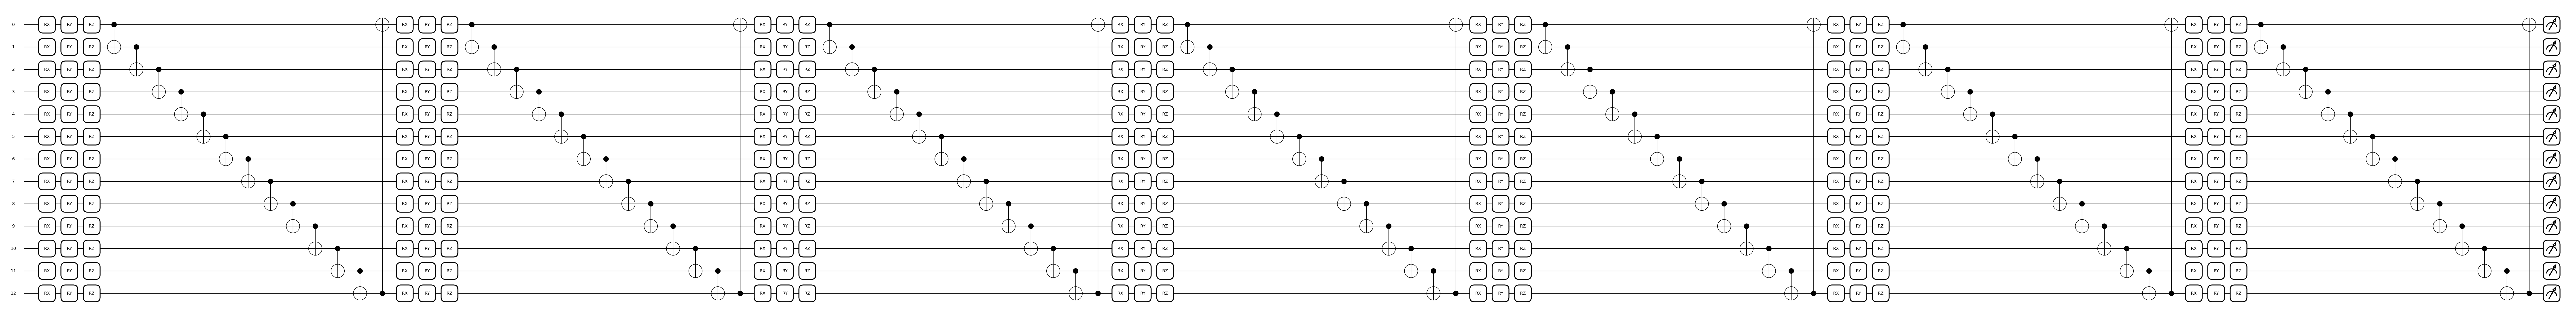

In [27]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [28]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds1, 3* total_qubits), dtype=torch.float32)
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.49186212113297517 Time taken per iter: 0.09999322891235352
Step: 20 Loss: 0.47836279697171574 Time taken per iter: 0.08906292915344238
Step: 30 Loss: 0.46715203743279526 Time taken per iter: 0.09799504280090332
Step: 40 Loss: 0.4564322548633433 Time taken per iter: 0.09398794174194336
Step: 50 Loss: 0.44719959493127726 Time taken per iter: 0.09435701370239258
Step: 60 Loss: 0.43538358960430734 Time taken per iter: 0.09253787994384766
Step: 70 Loss: 0.4207627674164807 Time taken per iter: 0.10204720497131348
Step: 80 Loss: 0.4026344073196263 Time taken per iter: 0.0876927375793457
Step: 90 Loss: 0.38362631081312476 Time taken per iter: 0.10011696815490723
Step: 100 Loss: 0.36258889204561057 Time taken per iter: 0.094451904296875
Step: 110 Loss: 0.3417908339718485 Time taken per iter: 0.10195207595825195
Step: 120 Loss: 0.31930305754320165 Time taken per iter: 0.101776123046875
Step: 130 Loss: 0.2920234929242654 Time taken per iter: 0.09742116928100586
Step: 140 Loss: 0.

Text(0.5, 1.0, 'Loss Over Epochs')

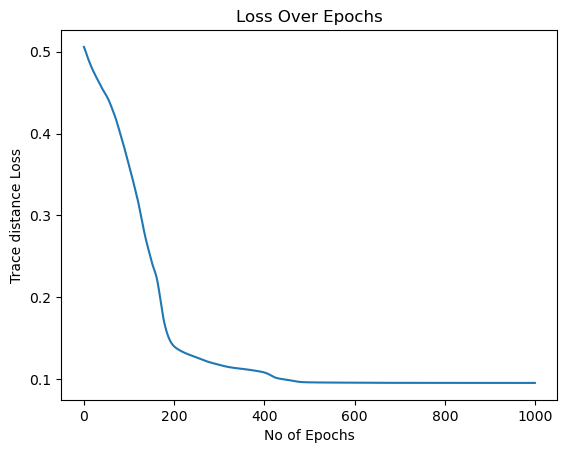

In [29]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [30]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.09518301704304169


In [31]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

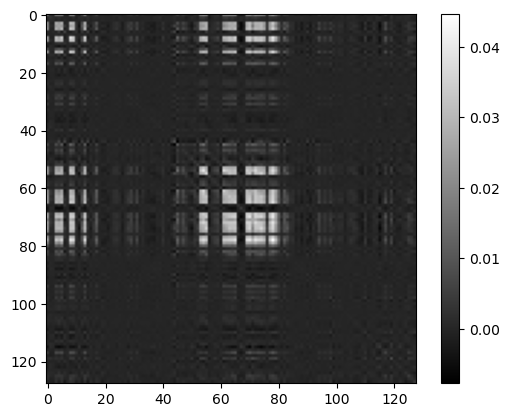

In [32]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

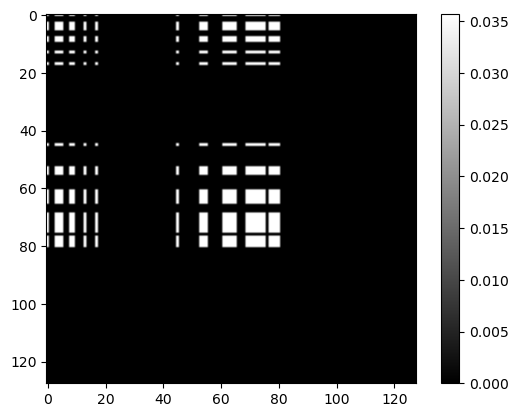

In [33]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

In [34]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])



dev2 = qml.device("default.mixed",wires=total_qubits)
folds2 = 3

@qml.qnode(dev2,interface="torch")
def reg_circuit(input_params,trained_params=optimal_params,folds=[folds1,folds2],num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(folds[0]):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds[1]):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)

    qml.QubitDensityMatrix(target_full_dm.conj().T, wires=range(total_qubits))
    
    output = qml.state()

    return output


In [35]:
reg_params = torch.rand((folds2, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 14300x1400 with 1 Axes>, <Axes: >)

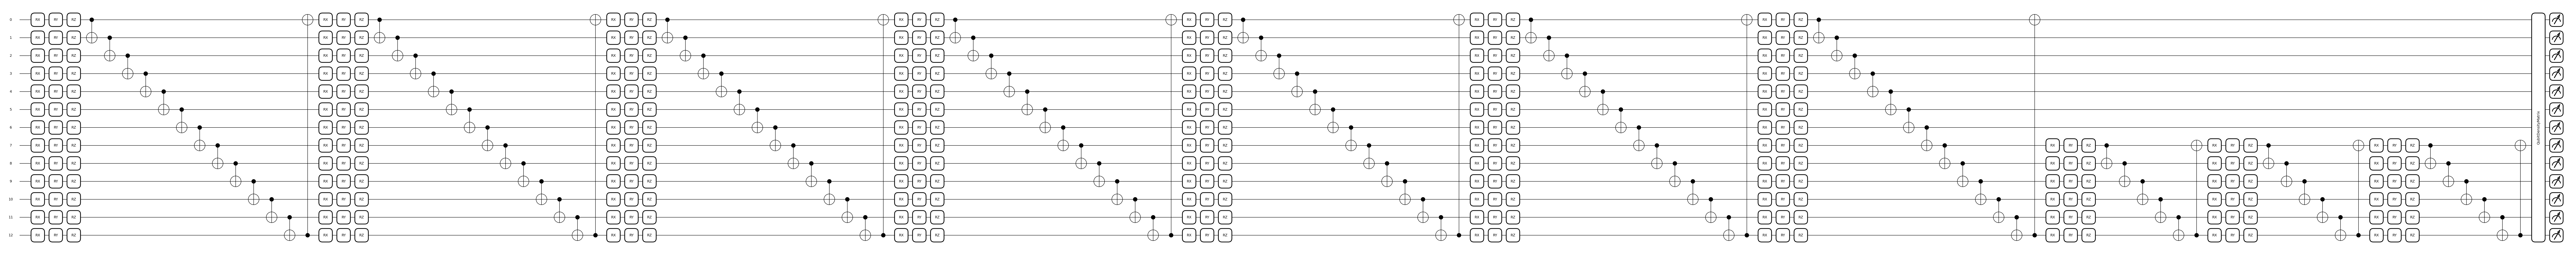

In [36]:
qml.draw_mpl(reg_circuit)(reg_params)

In [37]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds2, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_full_dm)
n_epochs = 200
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val.item())

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


KeyboardInterrupt: 

In [65]:
full_psi = reg_circuit(optimal_reg_params)

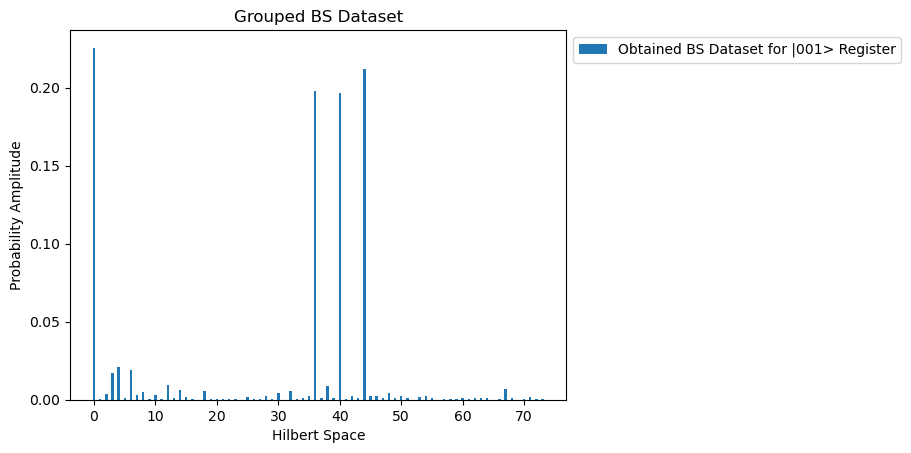

In [66]:
image = qnp.round(full_psi[::7],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

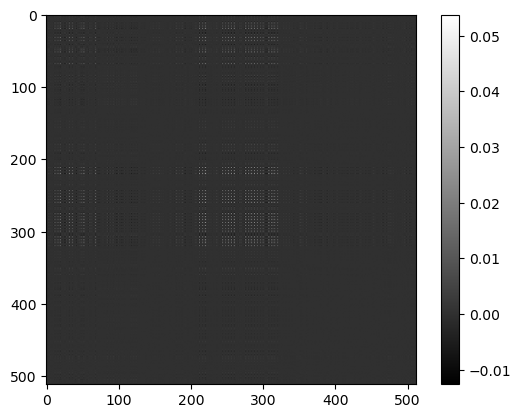

In [67]:
dm = qml.math.dm_from_state_vector(full_psi)
plt.imshow(dm.real,cmap="grey")
plt.colorbar()

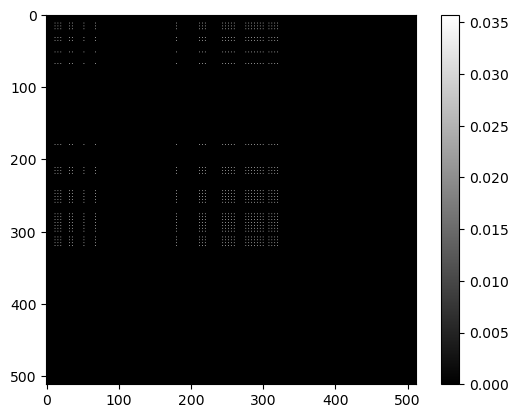

In [68]:
plt.imshow(target_full_dm.real,cmap="grey")
plt.colorbar()